<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/CNN_EDF_epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pywavelets
!pip install mne
!pip install pyedflib pywt matplotlib
!pip install pyedflib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mne
import pywt
import pyedflib
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt
  Using cached pyEDFlib-0.1.38-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
from os import listdir
os.chdir('/content/drive/MyDrive/edf_process/cnn_NN_learning')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        signals = np.zeros((n, f.getNSamples()[0]))
        for i in range(n):
            signals[i, :] = f.readSignal(i)
    return signals, signal_labels

In [5]:

def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):
    scale_max = 35
    scale_min = 10
    # массив точек с масштабом (линейный и логарифмический масштаб)
    scales = np.linspace(scale_min, scale_max, num = 25, endpoint=True)
    #scales = np.logspace(np.log10(scale_min), np.log10(scale_max), num = 25, endpoint=True, base=10.0)
    wavelet_core = 'morl'

    dt = 1/256
    coef, freqs = pywt.cwt(signal, scales, wavelet_core, sampling_period = dt)
    f = pywt.scale2frequency(wavelet_core, scales)/dt
    # изобразим график зависимости частоты и масштаба
    # plt.figure(figsize=(7, 7))
    # plt.grid()
    # plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
    # plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
    # plt.ylabel('Частота[Герц]', fontsize=12)
    # plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
    # plt.plot(scales, freqs,'.-')

    plt.figure(figsize=(10, 5))
    extent = [start_time, end_time, 1, 128]
    plt.imshow(np.abs(coef), extent=extent, cmap='jet', aspect='auto',
               vmax=np.percentile(np.abs(coef), 99))
    plt.colorbar(label='Magnitude')
    plt.title(f'Wavelet Transform of {file_name}')
    plt.ylabel('Scale')
    plt.xlabel('Time (seconds)')

    output_path = os.path.join(output_dir, f'{file_name}_{time_label}_wavelet.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()
    return output_path

In [6]:
def parse_summary_file(summary_file_path):
    edf_files = []
    with open(summary_file_path, 'r') as file:
        content = file.read()
        files = re.split(r'File Name: ', content)[1:]  # Разделение по файлам
        for file_info in files:
            lines = file_info.split('\n')
            file_name = lines[0].strip()
            seizure_start = []
            seizure_end = []
            num_seizures = 0
            for line in lines[1:]:
                if 'Number of Seizures in File' in line:
                    num_seizures = int(line.split(':')[-1].strip())
                for i in range(num_seizures):
                    if 'Seizure %d Start Time'%(i+1) in line:
                        seizure_start_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_start.append(seizure_start_i)
                    if 'Seizure %d End Time'%(i+1) in line:
                        seizure_end_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_end.append(seizure_end_i)
            edf_files.append({
                'file_name': file_name,
                'seizure_start': seizure_start,
                'seizure_end': seizure_end,
                'num_seizures': num_seizures
            })
    return edf_files


In [7]:
from scipy import signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

In [8]:
def subtract_windowed_mean(signal, window_count):
    len_int = len(signal) // window_count
    for i in range(window_count):
        window_idx = range(i * len_int, (i + 1) * len_int)
        window_mean = np.mean(signal[window_idx])
        signal[window_idx] -= window_mean
    return signal

In [9]:
def plot_signals(original_signal, mean_s, filtered_signal, time_window_start, time_window_end, sampling_rate):
    time = np.arange(time_window_start, time_window_end, 1/sampling_rate)

    plt.plot(time,original_signal, time, mean_s,time, filtered_signal)
    plt.legend(['original','mean','filtered'])
    plt.show()

In [11]:
# Директория для сохранения изображений на Google Диске
# Путь к текстовому файлу с информацией о приступах
output_dir = os.path.join(os.getcwd(), 'wavelet')
os.makedirs(output_dir, exist_ok=True)

In [13]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


In [14]:
import wfdb

https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel

https://wfdb.readthedocs.io/en/latest/convert.html?highlight=plot%20edf

In [34]:
!pip install git+https://github.com/MIT-LCP/wfdb-python.git

  Cloning https://github.com/MIT-LCP/wfdb-python.git to /tmp/pip-req-build-aaxyodpc
  Running command git clone --filter=blob:none --quiet https://github.com/MIT-LCP/wfdb-python.git /tmp/pip-req-build-aaxyodpc
  Resolved https://github.com/MIT-LCP/wfdb-python.git to commit c687060d6d98ff8f08911574f48853fafec81407
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [40]:
y = wfdb.io.convert.edf.read_edf('chb01_01.edf', verbose=True, pn_dir='chbmit/1.0.0/chb01')

EDF version number: 0
Patient ID: Surrogate Name                                                                  
Recording ID: 01                                                                              
Recording Date: 06.11.76
Recording Time: 11.42.54
Number of bytes in header record: 6144
Free Space: 
Number of data records: 3600
Duration of each data record in seconds: 1.0
Number of signals: 23
Signal Labels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
Transducer Types: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Physical Dimensions: ['uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV']
Physical Minimums: [-800. -800. -800. -800. -800. -800. -800. -800. -800. -800. -800. -8

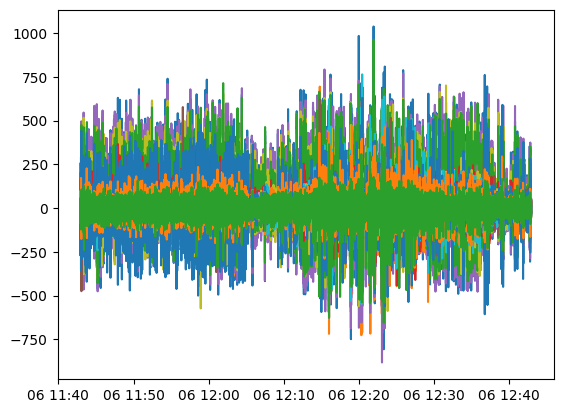

In [52]:
qwe = wfdb.io.record.Record.to_dataframe(y)
plt.plot(qwe)

In [38]:
eg_data, eeg_times = y.get_data(return_times=True)

AttributeError: 'Record' object has no attribute 'get_data'

In [ ]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))
# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 0*2200 +20)[0][0]
t_index_end = np.where(eeg_times > 0*2200 + 180)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

# удалаем ненужные сигналы из массива данных ЭЭГ
# в случае сигнала EEG_21 8 канал 'Value MKR+-MKR-'
eeg_data = np.delete(eeg_data, [len(eeg_data)-1], axis = 0)

In [12]:
# Директория с EDF-файлами
amount_of_chb=len([x for x in os.listdir("/content/drive/MyDrive/EEG/edfs/") if 'summary' in x])
print(amount_of_chb)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/EEG/edfs/'

10
[{'file_name': 'chb01_01.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_02.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_03.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 1}, {'file_name': 'chb01_04.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 1}, {'file_name': 'chb01_05.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_06.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_07.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_08.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_09.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_10.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb01_11.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file

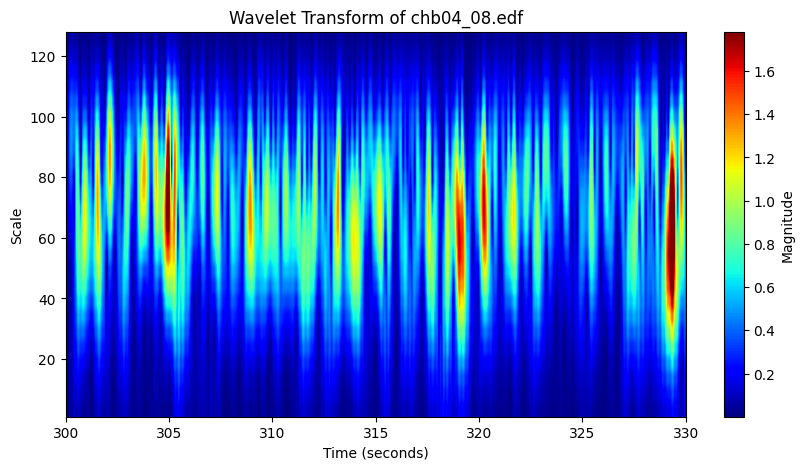

Файл /content/drive/MyDrive/EEG/edfs/chb04_09.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_10.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_11.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_12.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_13.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_14.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_15.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_16.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_17.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_18.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_19.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_21.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_22.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_23.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_24.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb04_25.edf не найден.
Файл /content/drive/MyDr

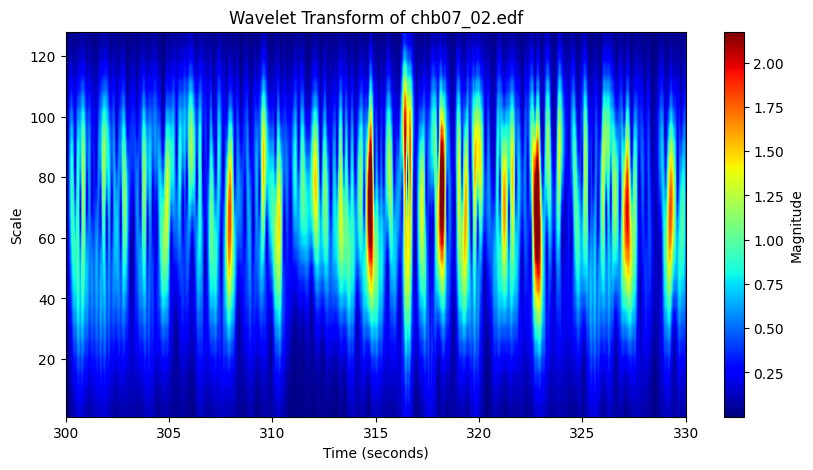

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


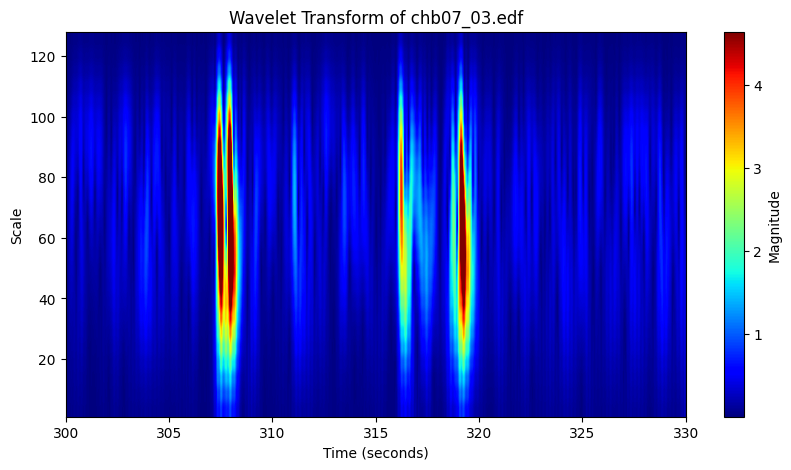

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


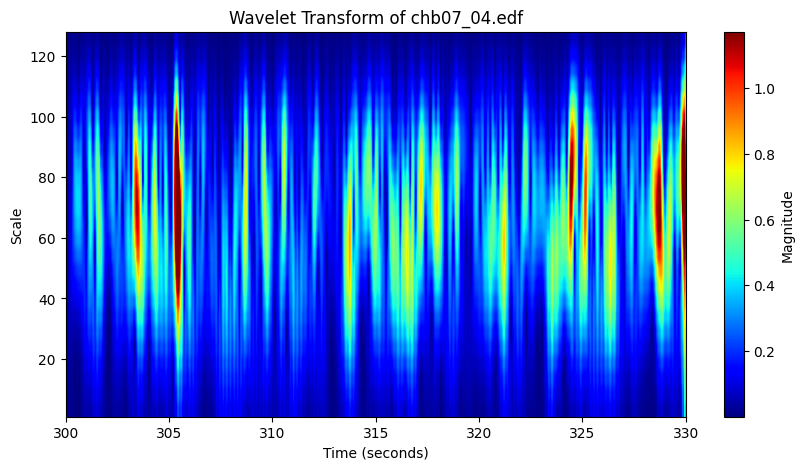

Файл /content/drive/MyDrive/EEG/edfs/chb07_05.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb07_06.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb07_07.edf не найден.
labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


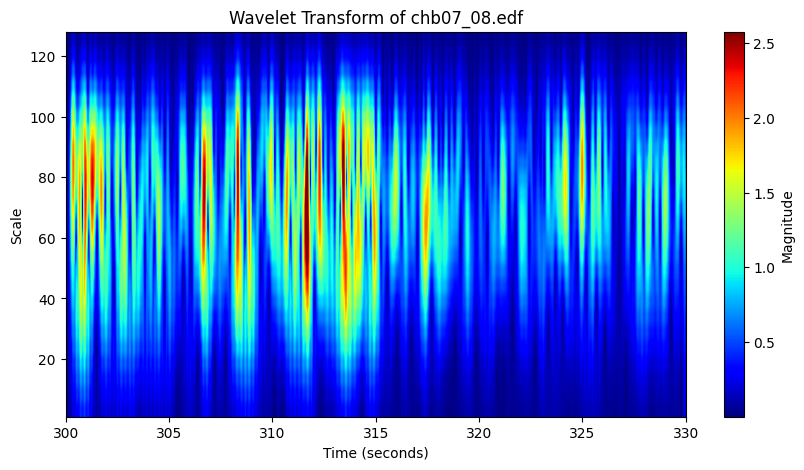

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


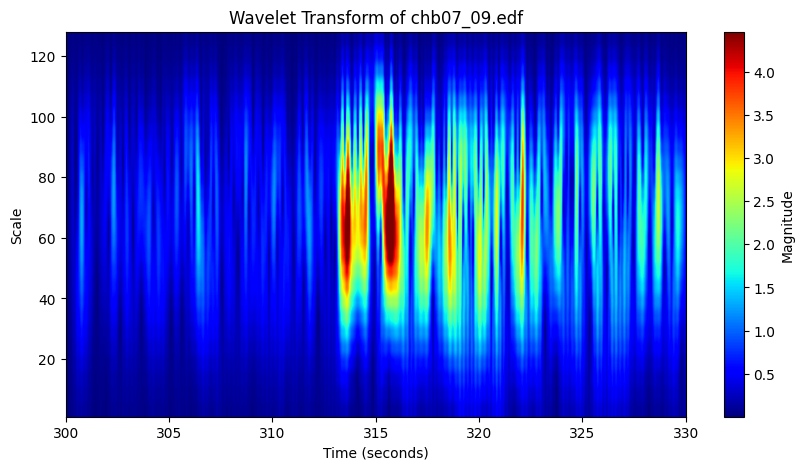

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


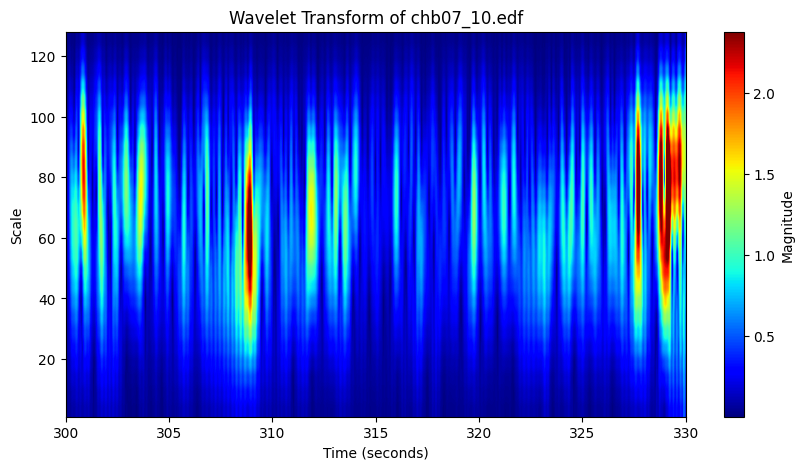

Файл /content/drive/MyDrive/EEG/edfs/chb07_11.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb07_12.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb07_13.edf не найден.
labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


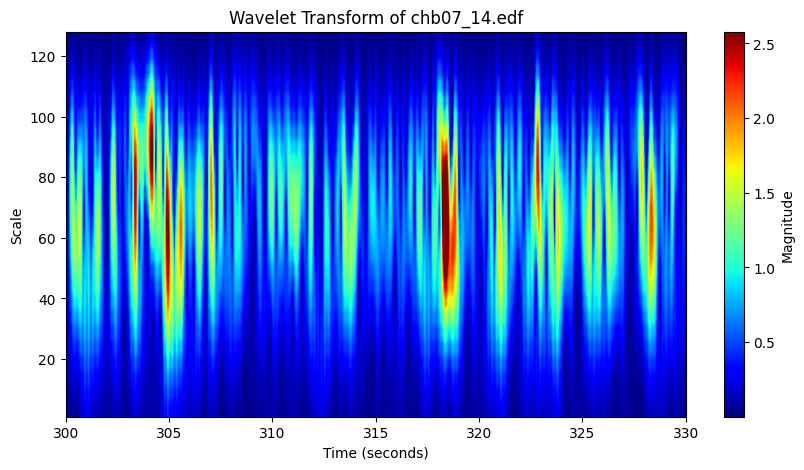

Файл /content/drive/MyDrive/EEG/edfs/chb07_15.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb07_16.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb07_17.edf не найден.
labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


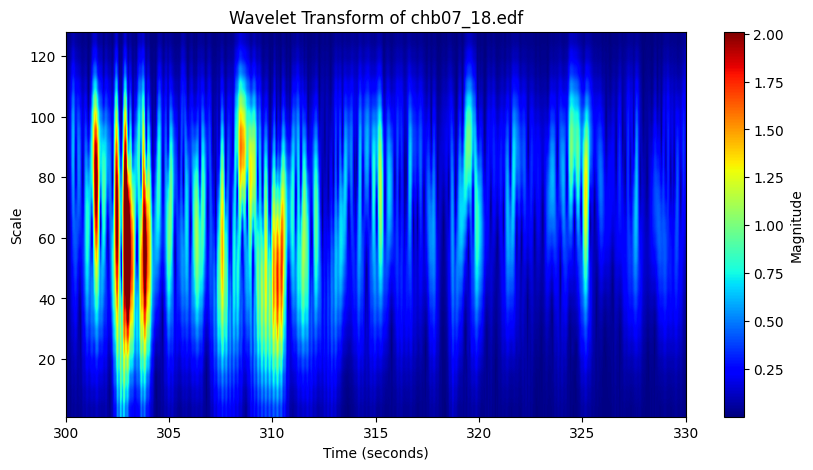

Файл /content/drive/MyDrive/EEG/edfs/chb07_19.edf не найден.
[{'file_name': 'chb08_02.edf', 'seizure_start': [2670], 'seizure_end': [2841], 'num_seizures': 1}, {'file_name': 'chb08_03.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb08_04.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb08_05.edf', 'seizure_start': [2856], 'seizure_end': [3046], 'num_seizures': 1}, {'file_name': 'chb08_10.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb08_11.edf', 'seizure_start': [2988], 'seizure_end': [3122], 'num_seizures': 1}, {'file_name': 'chb08_12.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb08_13.edf', 'seizure_start': [2417], 'seizure_end': [2577], 'num_seizures': 1}, {'file_name': 'chb08_14.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb08_15.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file

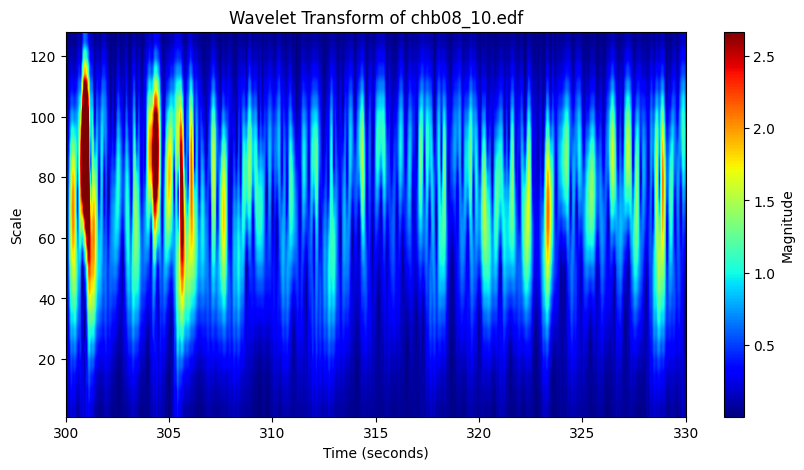

Файл /content/drive/MyDrive/EEG/edfs/chb08_11.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_12.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_13.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_14.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_15.edf не найден.
labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


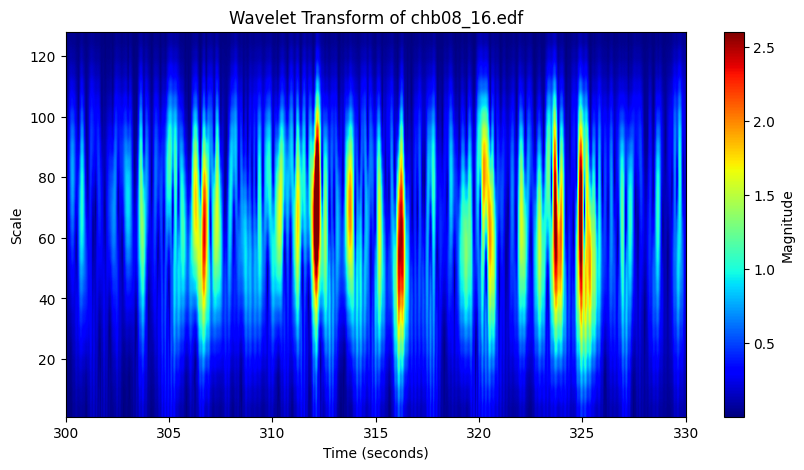

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


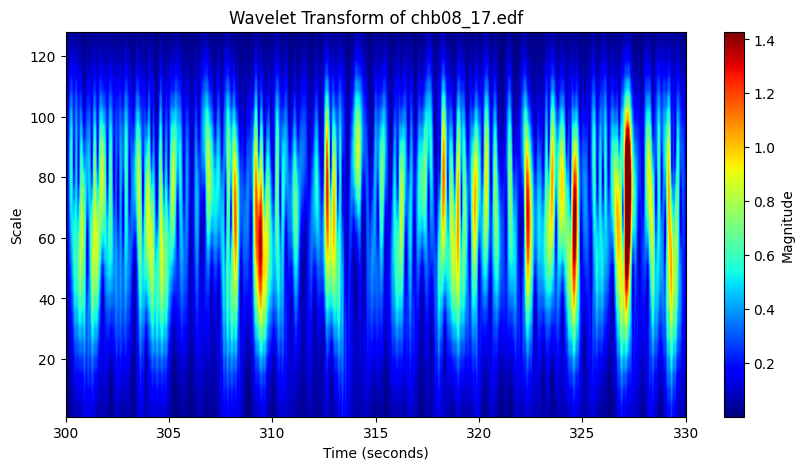

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


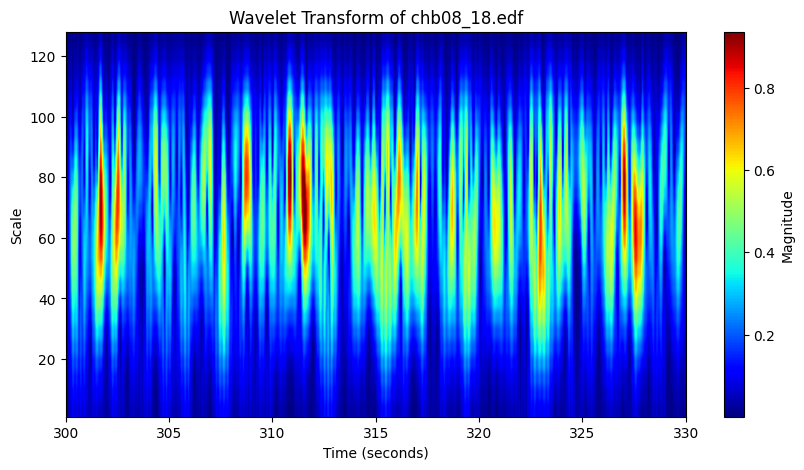

labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


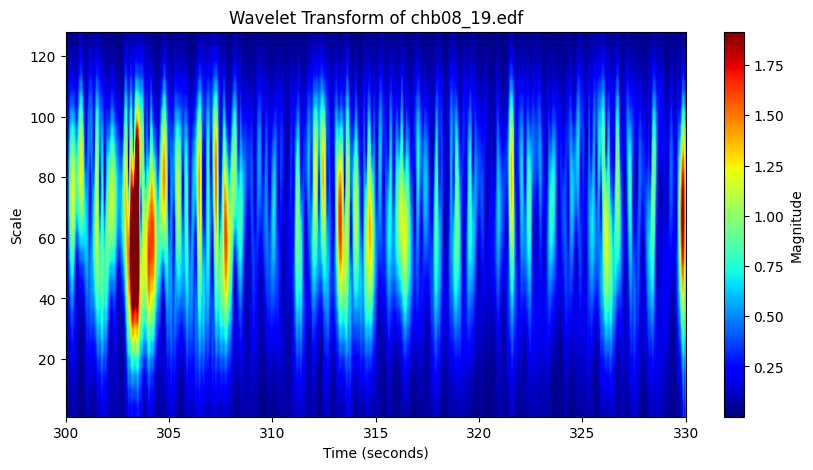

Файл /content/drive/MyDrive/EEG/edfs/chb08_20.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_21.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_22.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_23.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_24.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb08_29.edf не найден.
[{'file_name': 'chb09_01.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb09_02.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb09_03.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb09_04.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb09_05.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb09_06.edf', 'seizure_start': [12231], 'seizure_end': [12295], 'num_seizures': 1}, {'file_name': 'chb09_07.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures

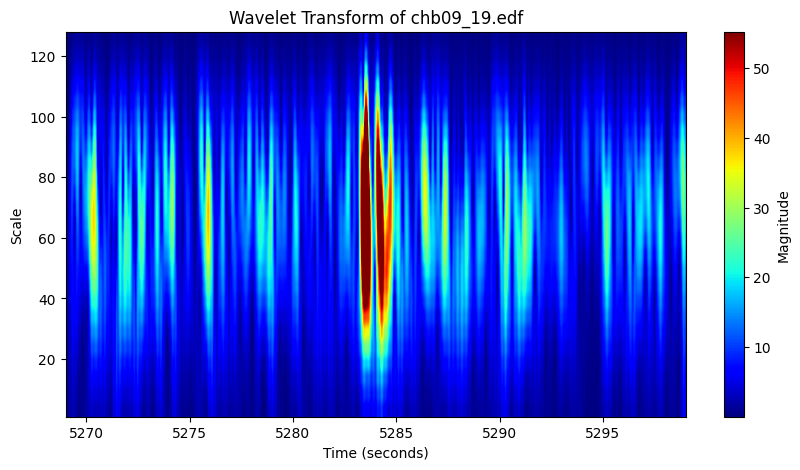

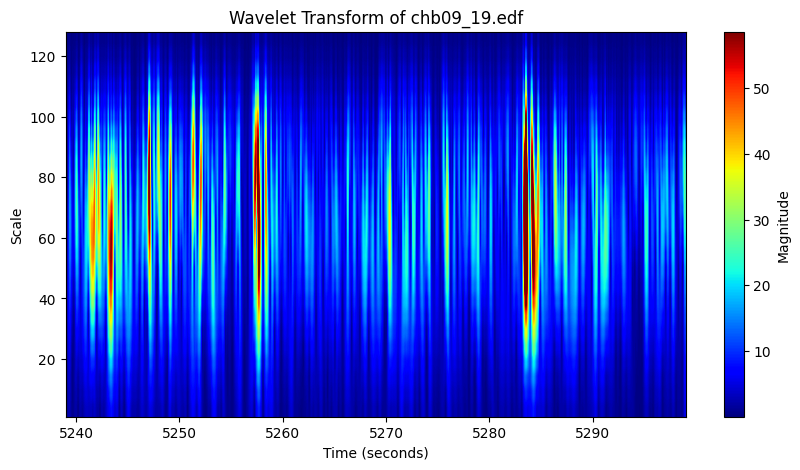

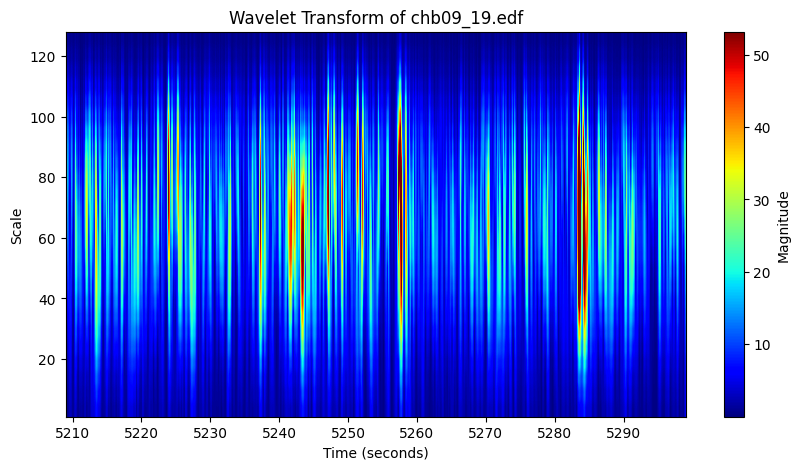

[{'file_name': 'chb10_01.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_02.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_03.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_04.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_05.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_06.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_07.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_08.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_12.edf', 'seizure_start': [6313], 'seizure_end': [6348], 'num_seizures': 1}, {'file_name': 'chb10_13.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {'file_name': 'chb10_14.edf', 'seizure_start': [], 'seizure_end': [], 'num_seizures': 0}, {

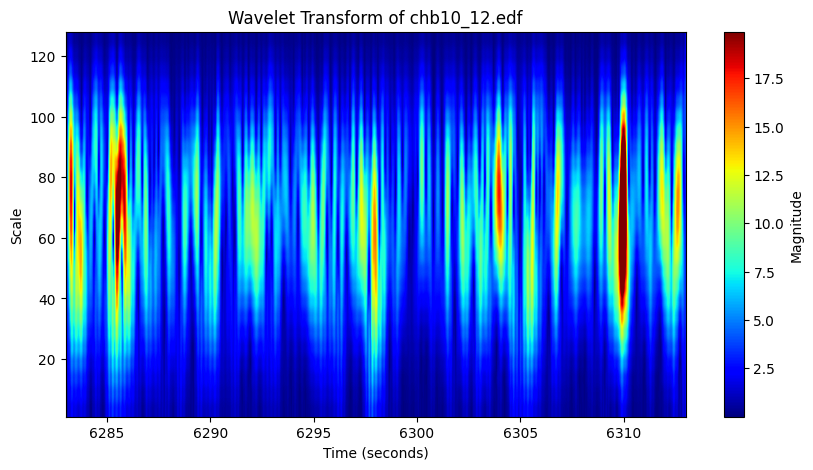

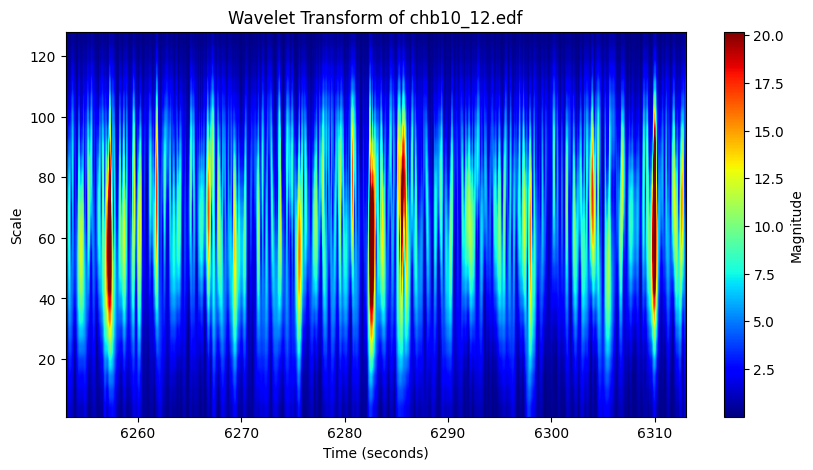

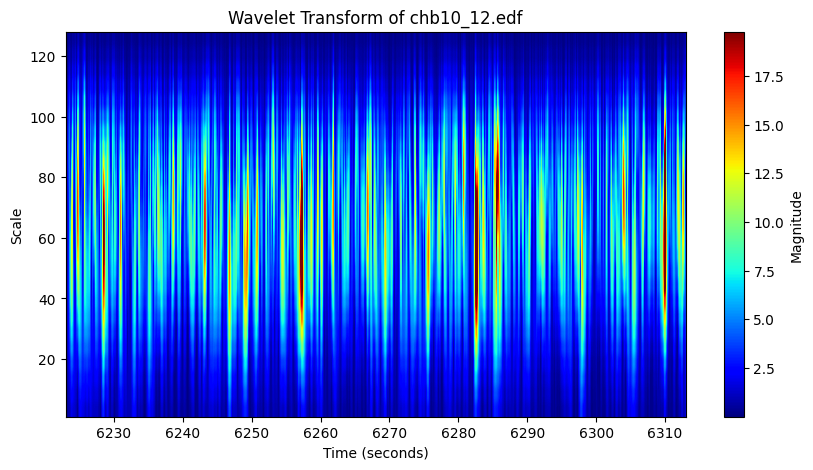

Файл /content/drive/MyDrive/EEG/edfs/chb10_13.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_14.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_15.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_16.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_17.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_18.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_19.edf не найден.
labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


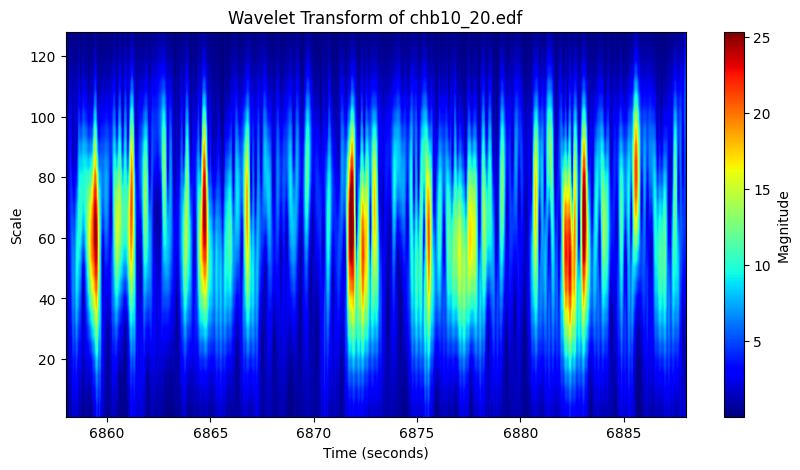

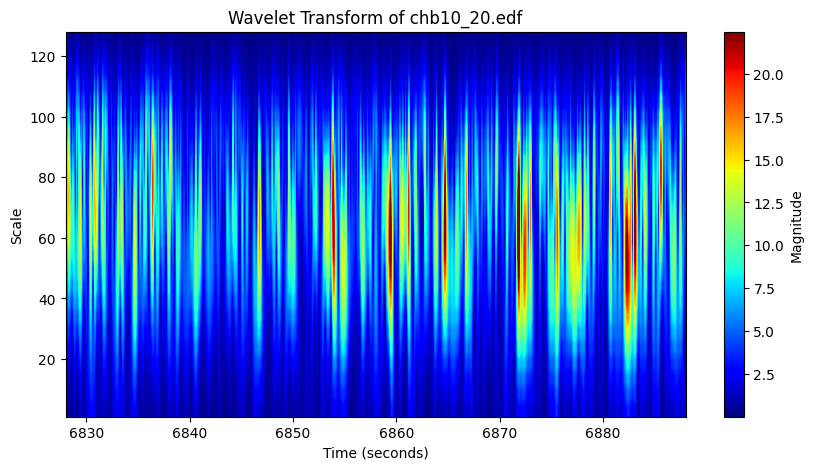

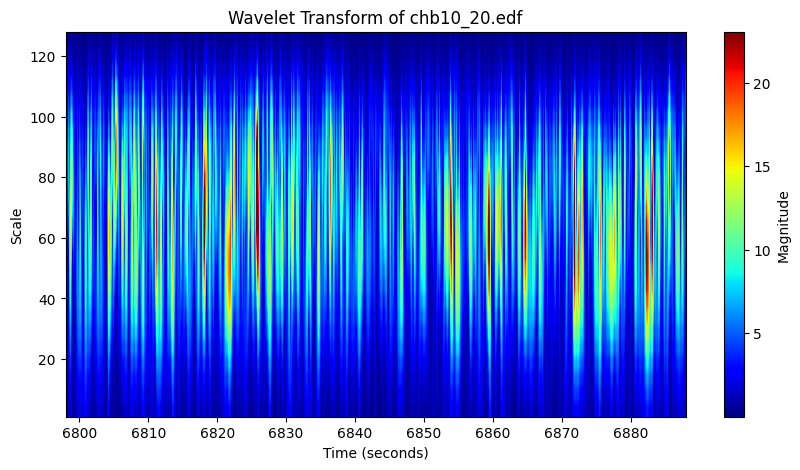

Файл /content/drive/MyDrive/EEG/edfs/chb10_21.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_22.edf не найден.
labels:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


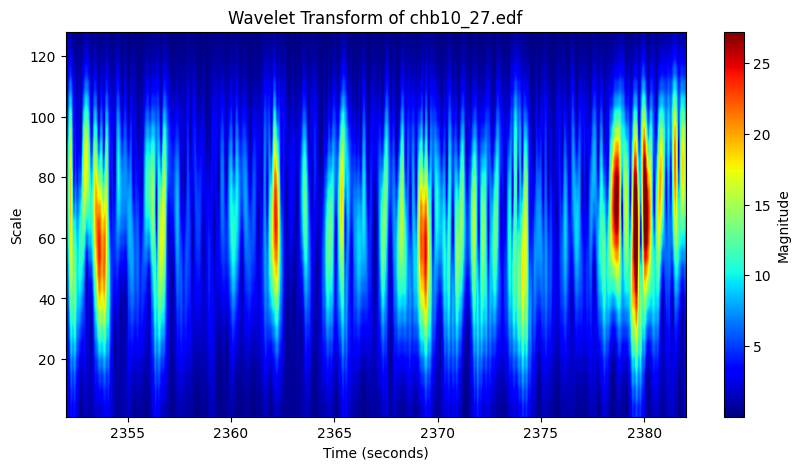

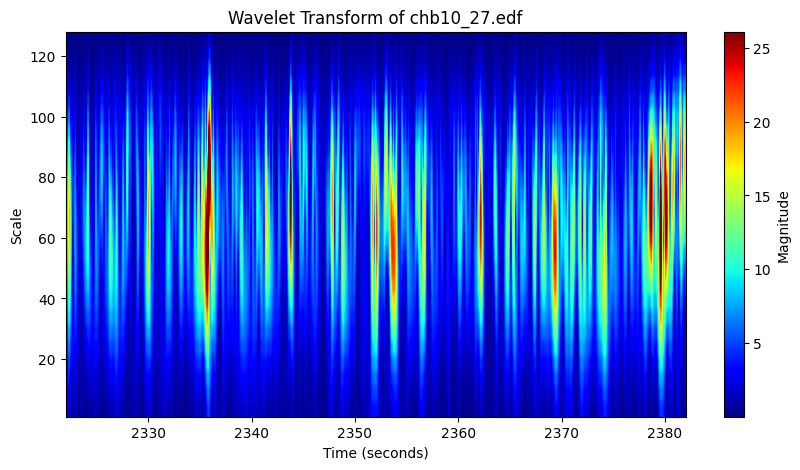

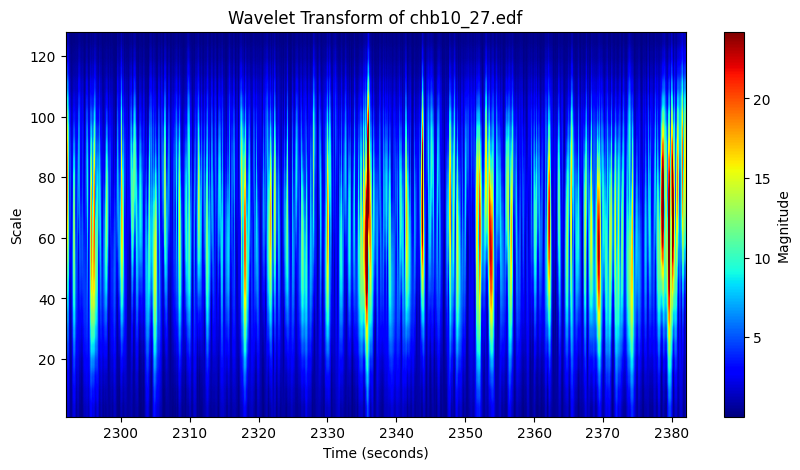

Файл /content/drive/MyDrive/EEG/edfs/chb10_28.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_30.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_31.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_38.edf не найден.
Файл /content/drive/MyDrive/EEG/edfs/chb10_89.edf не найден.


In [ ]:

    # Парсинг текстового файла для получения информации о приступах


    # Директория с EDF-файлами
    amount_of_chb=len([x for x in os.listdir("/content/drive/MyDrive/EEG/edfs/") if 'summary' in x])
    print(amount_of_chb)

    for spisok in range(amount_of_chb):
      summary_file_path = '/content/drive/MyDrive/EEG/edfs/chb0%d-summary.txt' % (spisok+1)
      edf_files = parse_summary_file(summary_file_path)
      edf_directory = os.path.join(os.getcwd(), 'edfs')
      print(edf_files)  # Fixed the print statement
      sampling_rate = 256
      lowcut = 8
      highcut = 13
      window_count = 4
      flag = 0
      for edf_file in edf_files:
          file_path = f"/content/drive/MyDrive/EEG/edfs/{edf_file['file_name']}"
          if not os.path.exists(file_path):
              print(f"Файл {file_path} не найден.")
              continue
          signals, labels = read_edf(file_path)
          print("labels: ",labels)
          a = len(signals)
          # Если есть приступ, генерируем изображения для 3 временных интервалов
          if len(edf_file['seizure_start']) != 0:
                flag = 1
                seizure_times = [(30, '30_sec_before'), (60, '60_sec_before'), (90, '90_sec_before')]
                for seiz_time in range(len(edf_file['seizure_start'])):
                  seizure_st = edf_file['seizure_start'][seiz_time]
                  seizure_en = edf_file['seizure_end'][seiz_time]

                  for time_offset, time_label in seizure_times:
                      time_window_start = seizure_st - time_offset
                      time_window_end = seizure_st  # Окно в 30 секунд
                      time_window_start_samples = time_window_start * sampling_rate
                      time_window_end_samples = time_window_end * sampling_rate
                      signal_s = np.delete(signals, [len(signals)-1], axis=0)

                      # Усреднение сигналов
                      avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
                      for i in range(a - 1):
                          avg_signal += signal_s[i, time_window_start_samples:time_window_end_samples]
                      avg_signal /= (a - 1)
                      avg_signal = subtract_windowed_mean(avg_signal, window_count)

                      original_signal = avg_signal.copy()
                      # Применение фильтра Баттерворта
                      filtered_signal = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=avg_signal,
                                                            lowcut=lowcut, highcut=highcut, fs=sampling_rate)
                      filtered_mean = subtract_windowed_mean(avg_signal, window_count)

                      # Определяем директорию и путь для сохранения изображения
                      save_dir = os.path.join(output_dir, 'Seizure')
                      os.makedirs(save_dir, exist_ok=True)

                      image_path = os.path.join(save_dir, f"{edf_file['file_name']}_{time_label}_wavelet.png")

                      # Проверка, существует ли изображение
                      # if os.path.exists(image_path):
                      #     print(f"Изображение {image_path} уже существует. Пропуск.")
                      #     continue

        # Сохранение изображения
                      image_path = save_wavelet_transform(filtered_signal, edf_file['file_name'], save_dir,
                                                        time_window_start, time_window_end, sampling_rate,time_label)
          else:
                # Обработка для записей без приступа (Healthy)
                flag = 0
                time_window_start = 300
                time_window_end = 330
                time_label = 30
                time_window_start_samples = time_window_start * sampling_rate
                time_window_end_samples = time_window_end * sampling_rate
                signals = np.delete(signals, [len(signals)-1], axis=0)

                # Усреднение сигналов
                avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
                avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
                for i in range(a-1):  # Проходим по всем каналам
                    avg_signal += signals[i, time_window_start_samples:time_window_end_samples]
                    avg_signal /= (a-1)  # Среднее значение по всем каналам
                avg_signal = subtract_windowed_mean(avg_signal, window_count)

                original_signal = avg_signal.copy()

                # Применение фильтра Баттерворта
                filtered_signal = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=avg_signal,
                                                      lowcut=lowcut, highcut=highcut, fs=sampling_rate)
                filtered_mean = subtract_windowed_mean(avg_signal, window_count)

                # Определяем директорию и путь для сохранения изображения
                save_dir = os.path.join(output_dir, 'Healthy')
                os.makedirs(save_dir, exist_ok=True)

                image_path = os.path.join(save_dir, f"{edf_file['file_name']}_healthy_wavelet.png")

                # Проверка, существует ли изображение
                # if os.path.exists(image_path):
                #     print(f"Изображение {image_path} уже существует. Пропуск.")
                #     continue

                # Сохранение изображения
                image_path = save_wavelet_transform(filtered_signal, edf_file['file_name'], save_dir,
                                                    time_window_start, time_window_end, sampling_rate,time_label)
if __name__ == "__main__":
    main()

['Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure' 'Seizure'
 'Seiz

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 100)              │         142,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 495,395 (1.89 MB)

 Trainable params: 495,395 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.5387 - loss: 1.5915 - val_accuracy: 0.5588 - val_loss: 1.5669
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6027 - loss: 1.5585 - val_accuracy: 0.5588 - val_loss: 1.5346
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5131 - loss: 1.5266 - val_accuracy: 0.5588 - val_loss: 1.5022
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6249 - loss: 1.4885 - val_accuracy: 0.5588 - val_loss: 1.4607
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.4476 - loss: 1.4384 - val_accuracy: 0.5588 - val_loss: 1.3675
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4898 - loss: 1.3100 - val_accuracy: 0.5588 - val_loss: 1.1965
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5690 - loss: 1.1676 - val_accuracy: 0.5588 - val_loss: 1.1001
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5635 - loss: 1.1071 - val_accuracy: 0.5588 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


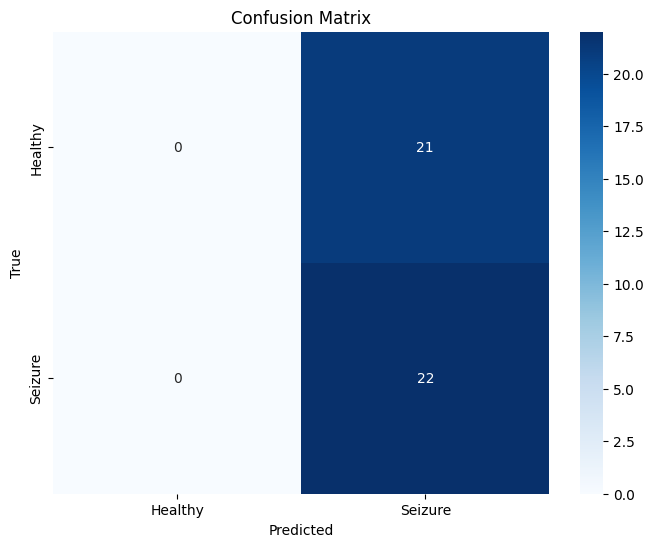

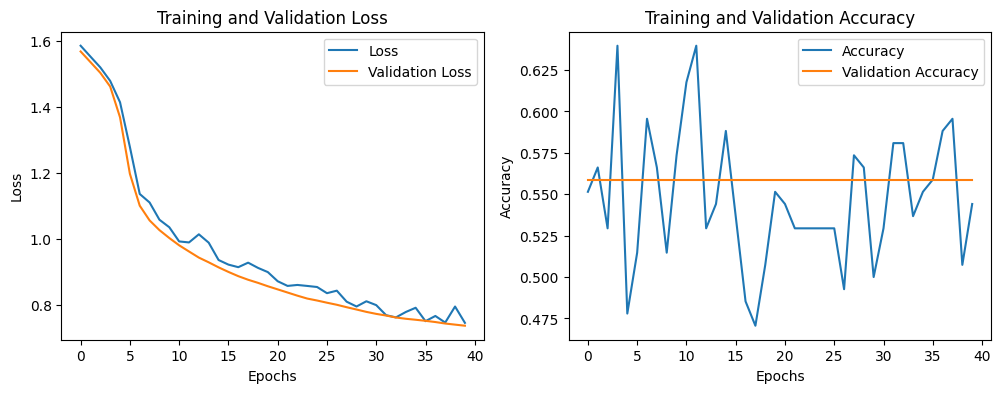

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Функция для загрузки изображений вейвлет-преобразования
def load_wavelet_images(image_dir):
    images = []
    labels = []
    for class_dir in os.listdir("/content/drive/MyDrive/EEG/wavelet"):
        class_path = os.path.join(image_dir, class_dir)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            img = tf.image.resize(img, [64, 64])
            images.append(img)
            labels.append(class_dir)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# print(os.path.realpath())


# Загрузка данных и подготовка
image_dir = '/content/drive/MyDrive/EEG/wavelet'  # Путь к директории с изображениями
X, y = load_wavelet_images(image_dir)

# Масштабирование данных и изменение размерности для нейронной сети
X/=255

# Преобразование меток в one-hot encoding
label_mapping = {'Healthy': 0, 'Seizure': 1}
print(y)
y = np.array([label_mapping[label] for label in y])
y = to_categorical(y, num_classes=3)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели CNN-LSTM
def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # CNN layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(MaxPooling2D((2, 2)))

    # Увеличение количества dropout для уменьшения переобучения
    model.add(Dropout(0.6))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flatten and LSTM layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Reshape((1, -1)))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(100))
    model.add(Dropout(0.5))

    # Fully connected layers
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 класса для классификации

    # Компиляция модели
    # Компиляция модели с использованием правильного аргумента 'learning_rate'
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


    return model

# Инициализация модели
input_shape = (64, 64, 4)
model = create_cnn_lstm_model(input_shape)
model.summary()

# Обучение модели
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2)

# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Печать результатов оценки
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred_classes)
# Визуализация матрицы ошибок с помощью heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Визуализация процесса обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()
